In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import LSTM, GRU, Bidirectional
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from datetime import datetime
from keras import optimizers
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from numpy import savetxt
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
import seaborn as sns

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Wanshouxigong.csv to Wanshouxigong.csv


In [ ]:
data=read_csv("Wanshouxigong.csv")
data

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM
0,1,2013,3,1,0,9.0,9.0,6.0,17.0,200.0,62.0,0.3,1021.9,-19.0,0.0,WNW,2.0
1,2,2013,3,1,1,11.0,11.0,7.0,14.0,200.0,66.0,-0.1,1022.4,-19.3,0.0,WNW,4.4
2,3,2013,3,1,2,8.0,8.0,NaN,16.0,200.0,59.0,-0.6,1022.6,-19.7,0.0,WNW,4.7
3,4,2013,3,1,3,8.0,8.0,3.0,16.0,NaN,NaN,-0.7,1023.5,-20.9,0.0,NW,2.6
4,5,2013,3,1,4,8.0,8.0,3.0,NaN,300.0,36.0,-0.9,1024.1,-21.7,0.0,WNW,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,35060,2017,2,28,19,11.0,32.0,3.0,24.0,400.0,72.0,12.5,1013.5,-16.2,0.0,NW,2.4
35060,35061,2017,2,28,20,13.0,32.0,3.0,41.0,500.0,50.0,11.6,1013.6,-15.1,0.0,WNW,0.9
35061,35062,2017,2,28,21,14.0,28.0,4.0,38.0,500.0,54.0,10.8,1014.2,-13.3,0.0,NW,1.1
35062,35063,2017,2,28,22,12.0,23.0,4.0,30.0,400.0,59.0,10.5,1014.4,-12.9,0.0,NNW,1.2


In [ ]:
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset = pd.read_csv('Wanshouxigong.csv',index_col=0, date_parser=parse,parse_dates=[['year', 'month', 'day', 'hour']])

In [ ]:
dataset.drop("No", axis=1, inplace=True)

In [ ]:
dataset=dataset.fillna(method="pad")

In [ ]:
dataset.isnull().sum()

PM2.5    0
PM10     0
SO2      0
NO2      0
CO       0
O3       0
TEMP     0
PRES     0
DEWP     0
RAIN     0
wd       0
WSPM     0
dtype: int64

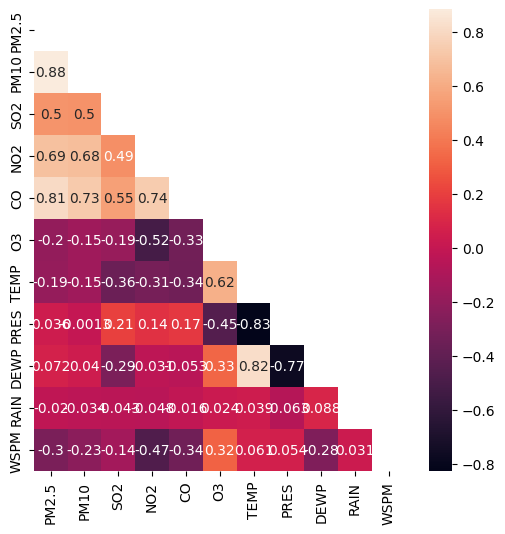

In [ ]:
# applying mask
mask = np.triu(np.ones_like(dataset.corr()))
f, ax = plt.subplots(figsize=(6, 6))
# plotting a triangle correlation heatmap
dataplot = sns.heatmap(dataset.corr(),annot=True, mask=mask)
plt.savefig(r'./Aotiheat.jpg', dpi=400) 
# displaying heatmap
plt.show()

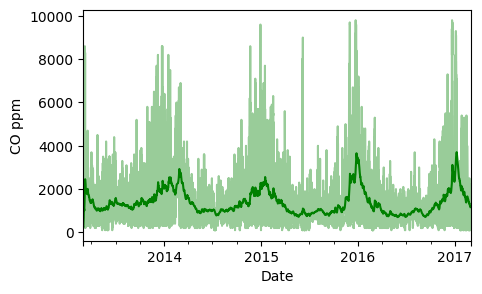

In [ ]:
f = plt.figure()
f.set_figwidth(5)
f.set_figheight(3)
dataset['CO'].to_frame()
#f.set_figwidth(5)
#f.set_figheight(3)
p=dataset["CO"].plot(color= "green", alpha=0.4)
#p=dataset['PM2.5'].rolling(168).mean().plot(color= "green")
p=dataset['CO'].ewm(span=720).mean().plot(color= "green")
p.set_xlabel('Date')
p.set_ylabel('CO ppm')
plt.savefig(r'./CO.jpg', dpi=400)
plt.show()

In [ ]:
temp_cols=dataset.columns.tolist()
index=dataset.columns.get_loc("CO")
new_cols=temp_cols[index:index+1] + temp_cols[0:index] + temp_cols[index+1:]
dataset=dataset[new_cols]

In [ ]:
dataset.describe()

,CO,PM2.5,PM10,SO2,NO2,O3,TEMP,PRES,DEWP,RAIN,WSPM
count,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000
mean,1376.914243,85.356562,112.729215,17.369966,55.643387,55.978065,13.782290,1011.516363,2.705590,0.064285,1.745317
std,1238.856861,86.627607,98.700415,24.270784,36.092564,57.165967,11.386498,10.571637,13.705357,0.796766,1.206447
min,100.000000,3.000000,2.000000,0.285600,2.000000,0.214200,-16.800000,985.100000,-35.300000,0.000000,0.000000
25%,600.000000,22.000000,39.000000,3.000000,28.000000,8.000000,3.400000,1002.800000,-8.500000,0.000000,0.900000
50%,1000.000000,60.000000,91.000000,8.000000,49.000000,42.000000,14.800000,1011.000000,3.300000,0.000000,1.400000
75%,1700.000000,117.000000,154.000000,21.000000,77.000000,82.000000,23.500000,1020.000000,15.200000,0.000000,2.300000
max,9800.000000,999.000000,961.000000,411.000000,251.000000,358.000000,40.600000,1042.000000,28.500000,46.400000,13.200000


In [ ]:
dataset_columns = dataset.columns.tolist()
dataset_columns

['CO',
 'PM2.5',
 'PM10',
 'SO2',
 'NO2',
 'O3',
 'TEMP',
 'PRES',
 'DEWP',
 'RAIN',
 'wd',
 'WSPM']

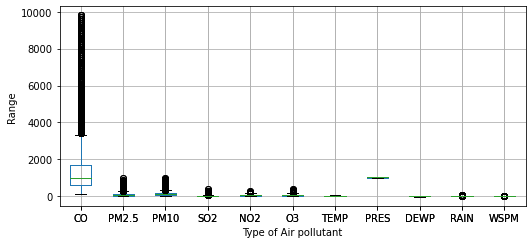

In [ ]:
#Box plot
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
dataset.boxplot()
p = dataset.boxplot(grid=True)
p.set_xlabel('Type of Air pollutant')
p.set_ylabel('Range')

plt.savefig(r'./isobaric.jpg', dpi=400)
plt.show()

/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


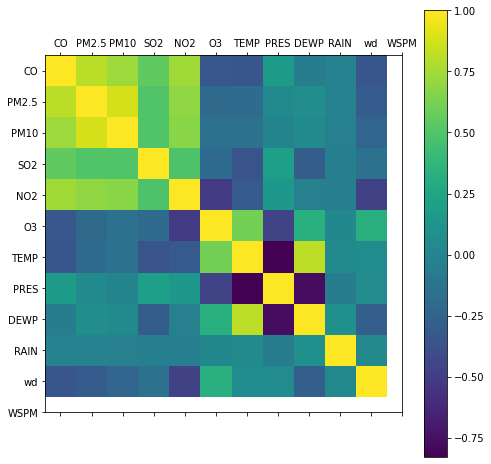

In [ ]:
#Analysing relationship between different features
cor_cols = dataset_columns
plt.rcParams["figure.figsize"] = [8, 8]
plt.rcParams["figure.autolayout"] = True
plt.matshow(dataset.corr())
plt.xticks(range(len(cor_cols)), cor_cols)
plt.yticks(range(len(cor_cols)), cor_cols)
corrr = plt.colorbar()
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode non categorical values
values = dataset.values
encoder = LabelEncoder()
values[:,10] = encoder.fit_transform(values[:,10])
values = values.astype('float32')
values[:,10]

array([14., 14., 14., ...,  7.,  6.,  5.], dtype=float32)

In [ ]:
values

array([[200. ,   9. ,   9. , ...,   0. ,  14. ,   2. ],
       [200. ,  11. ,  11. , ...,   0. ,  14. ,   4.4],
       [200. ,   8. ,   8. , ...,   0. ,  14. ,   4.7],
       ...,
       [500. ,  14. ,  28. , ...,   0. ,   7. ,   1.1],
       [400. ,  12. ,  23. , ...,   0. ,   6. ,   1.2],
       [600. ,  13. ,  19. , ...,   0. ,   5. ,   1.3]], dtype=float32)

In [ ]:
#Normalising data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(values)

In [ ]:
#Creating a window for previous data
def to_supervised(train):
  window_size = 24
  X = []
  Y = []
  for i in range(window_size, len(train)):
    X.append(train[i-window_size:i,:])
    Y.append(train[i,0:1])
    
  return X,Y

In [ ]:
X, Y = to_supervised(scaled_dataset)
X = np.array(X)
Y = np.array(Y)
print('Y' ,Y.shape)
print('X' ,X.shape)

Y (35040, 1)
X (35040, 24, 12)


In [ ]:
#Splitting the dataset
n_train = 24*365
X_train, X_test = X[n_train:,] , X[:n_train,]
print('X_train' ,X_train.shape)
print('X_test' ,X_test.shape)

Y_train, Y_test = Y[n_train:,] , Y[:n_train,]
print('Y_train' ,Y_train.shape)
print('Y_test' ,Y_test.shape)

X_train (26280, 24, 12)
X_test (8760, 24, 12)
Y_train (26280, 1)
Y_test (8760, 1)


In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(units = 50, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2]))))
model.add(Dropout(0.2))

model.add(Bidirectional(GRU(units = 50, return_sequences = True)))
model.add(Dropout(0.2))

model.add(Bidirectional(GRU(units = 50, return_sequences = True)))
model.add(Dropout(0.2))


model.add(Bidirectional(GRU(units = 50)))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error') 

In [ ]:
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath="/save.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)
tb = TensorBoard('logs')
history = model.fit(X_train, Y_train, epochs=100, batch_size=64,callbacks=[mcp,rlr],validation_data=(X_test, Y_test), verbose=1, shuffle=False)


Epoch 1/100
411/411 [==============================] - ETA: 0s - loss: 0.0065
Epoch 1: val_loss improved from inf to 0.01528, saving model to /save.h5
411/411 [==============================] - 76s 145ms/step - loss: 0.0065 - val_loss: 0.0153 - lr: 0.0010
Epoch 2/100
411/411 [==============================] - ETA: 0s - loss: 0.0044
Epoch 2: val_loss improved from 0.01528 to 0.00977, saving model to /save.h5
411/411 [==============================] - 54s 131ms/step - loss: 0.0044 - val_loss: 0.0098 - lr: 0.0010
Epoch 3/100
411/411 [==============================] - ETA: 0s - loss: 0.0031
Epoch 3: val_loss improved from 0.00977 to 0.00479, saving model to /save.h5
411/411 [==============================] - 56s 136ms/step - loss: 0.0031 - val_loss: 0.0048 - lr: 0.0010
Epoch 4/100
411/411 [==============================] - ETA: 0s - loss: 0.0024
Epoch 4: val_loss did not improve from 0.00479
411/411 [==============================] - 57s 138ms/step - loss: 0.0024 - val_loss: 0.0053 - lr: 0

In [ ]:
from keras.models import load_model
model.save('AirPollutionBiLSTMGRU.h5')

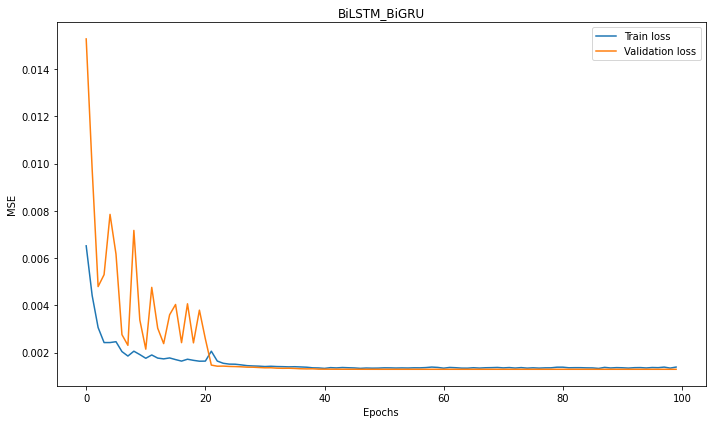

<Figure size 576x576 with 0 Axes>

In [ ]:
plt.figure(figsize=(10,6))  
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title("BiLSTM_BiGRU")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.show()
plt.savefig('Traingraph.png')

In [ ]:
RMSE1=[]
RMAE1=[]
MAPE1=[]
R22=[]

for i in range(40, 181, 5):
  Y_pred = model.predict(X_test[:i,:])
  #print(Y_pred)
  #Scaling back to the original scale
  d = scaled_dataset[:i,:]
  Y_predicted = np.concatenate((Y_pred,d[:,1:]), axis =1)
  Y_tested = np.concatenate((Y_test[:i,], d[:i,1:]), axis = 1)
  #Scaling back to the original scale
  d = scaled_dataset[:i,:]
  Y_predicted = np.concatenate((Y_pred,d[:i,1:]), axis =1)
  Y_tested = np.concatenate((Y_test[:i,], d[:i,1:]), axis = 1)
  Y_predicted = scaler.inverse_transform(Y_predicted)
  Y_tested = scaler.inverse_transform(Y_tested)
  Y_predicted = Y_predicted[:,0:1]
  Y_tested = Y_tested[:i,0:1]
  mse = mean_squared_error(Y_tested, Y_predicted)
  rmse = np.sqrt(mse)
  print("RMSE at %s = %s" % (i, rmse))
  RMSE1=np.append(RMSE1,rmse)
  mae = mean_absolute_error(Y_tested, Y_predicted)
  rmae = np.sqrt(mae)
  RMAE1=np.append(RMAE1,rmae)
  print("RMAE at %s = %s" % (i, rmae))
  mape = mean_absolute_percentage_error(Y_tested, Y_predicted)
  print("MAPE at %s = %s" % (i, mape))
  MAPE1=np.append(MAPE1,mape)
  #R2 score
  R2 = r2_score( Y_predicted, Y_tested)
  print("R2 at %s = %s" % (i, R2))
  R22=np.append(R22,R2)

2/2 [==============================] - 0s 16ms/step
RMSE at 40 = 274.4786
RMAE at 40 = 13.748259
MAPE at 40 = 0.17529604
R2 at 40 = 0.8955782900931742
2/2 [==============================] - 0s 19ms/step
RMSE at 45 = 272.7528
RMAE at 45 = 13.961303
MAPE at 45 = 0.17418966
R2 at 45 = 0.8866286404002608
2/2 [==============================] - 0s 20ms/step
RMSE at 50 = 346.17786
RMAE at 50 = 15.60705
MAPE at 50 = 0.2131009
R2 at 50 = 0.8042192829508755
2/2 [==============================] - 0s 21ms/step
RMSE at 55 = 345.71378
RMAE at 55 = 15.598955
MAPE at 55 = 0.2406308
R2 at 55 = 0.8060697234620471
2/2 [==============================] - 0s 24ms/step
RMSE at 60 = 336.77066
RMAE at 60 = 15.338449
MAPE at 60 = 0.23948379
R2 at 60 = 0.8117382431071584
3/3 [==============================] - 0s 20ms/step
RMSE at 65 = 323.73
RMAE at 65 = 14.83053
MAPE at 65 = 0.2279974
R2 at 65 = 0.8306845916361794
3/3 [==============================] - 0s 18ms/step
RMSE at 70 = 313.86295
RMAE at 70 = 14.546009


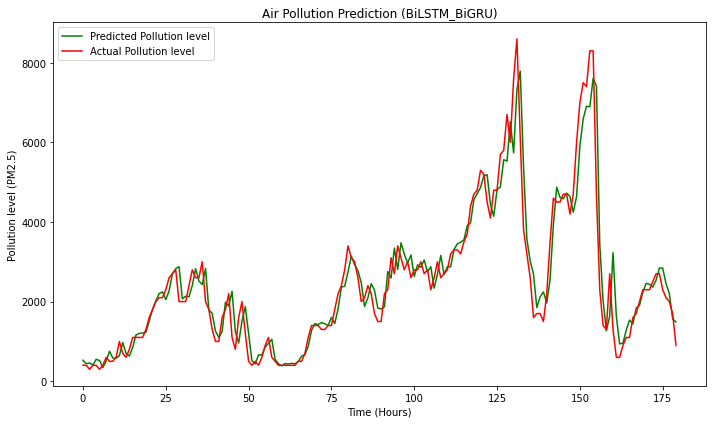

<Figure size 576x576 with 0 Axes>

In [ ]:
plt.figure(figsize=(10,6))  
plt.plot(Y_predicted, color= 'green',label = 'Predicted Pollution level')
plt.plot(Y_tested , color = 'red',label = 'Actual Pollution level')
plt.title("Air Pollution Prediction (BiLSTM_BiGRU)")
plt.xlabel("Time (Hours)")
plt.ylabel("Pollution level (PM2.5)")
plt.legend()
plt.show()
plt.savefig('graphBiLSTMBi_GRU_co.png')

In [ ]:
savetxt('Predict_BiLSTM_BiGRU_CO.csv', Y_predicted, delimiter=',')

In [ ]:
savetxt('Test_BiLSTMBiGRU_CO.csv', Y_test, delimiter=',')